# Classifier Guidance

In [1]:
import json
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.1",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [3]:
# load the hyperparameters
with open("checkpoints/best_hyperparams.json", "r") as f:
    best_hyperparams = json.load(f)
print("Best hyperparameters loaded:", best_hyperparams)

dropout_rate = best_hyperparams.get("dropout_rate", 0.13979156262153372)

model = models.efficientnet_b3(pretrained=False)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(1536, 512),
    torch.nn.SiLU(inplace=True),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Linear(512, 5)
)
model.load_state_dict(torch.load("checkpoints/final_guidance_classifier.pth"))
model.eval()
model.to(device)

Best hyperparameters loaded: {'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}


c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sandr\AppData\Local\Temp\ipykernel_32020\2805766729.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [10]:
prompt = "Close up, angry cowboy walks toward his wooden ranch in the Wild West"

  0%|          | 0/50 [00:00<?, ?it/s]

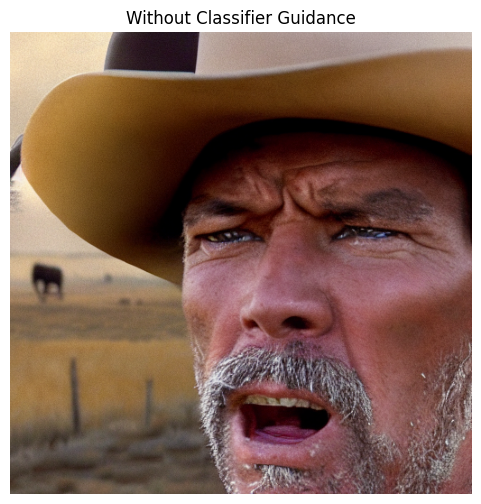

In [11]:
# Baseline Image (No Guidance)
baseline_image = pipe(prompt).images[0]
baseline_image.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(baseline_image)
ax.set_title("Without Classifier Guidance")
ax.axis("off")

plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
def classifier_score(image):
    """Compute classifier confidence for each shot type."""
    image = transform(image).unsqueeze(0).to("cuda")
    with torch.no_grad():
        output = model(image)
        probs = F.softmax(output, dim=1)  # Convert to probabilities
    return probs

In [ ]:
def guided_sampling(prompt, classifier_target_label, num_inference_steps=50, guidance_scale=7.5, classifier_strength=0.1, classifier_interval=5):
    """Generate an image guided towards a specific classifier label with less frequent classifier evaluations."""
    
    # Encode the prompt using the text encoder
    text_inputs = pipe.tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_inputs)[0]
    
    latents = torch.randn((1, 4, 64, 64), dtype=torch.float16).to(device)
    
    # Initialize guidance score
    target_score = 0.0

    for t in range(num_inference_steps):
        t_tensor = torch.tensor([t], dtype=torch.long, device=device)
        
        # Predict noise using the U-Net with text conditioning
        with torch.no_grad():
            noise_pred = pipe.unet(latents, t_tensor, encoder_hidden_states=text_embeddings).sample
        
        # Perform scheduler step
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
        
        # Evaluate classifier every classifier_interval steps
        if t % classifier_interval == 0:
            with torch.no_grad():
                image = pipe.decode_latents(latents.detach())
            pil_image = pipe.numpy_to_pil(image)[0]
            
            # Get classifier confidence
            scores = classifier_score(pil_image)
            target_score = scores[0, classifier_target_label].item()
        
        # Adjust latents based on classifier confidence
        latents = latents + (target_score * classifier_strength)
    
    with torch.no_grad():
        final_image = pipe.decode_latents(latents.detach())
    return pipe.numpy_to_pil(final_image)[0]

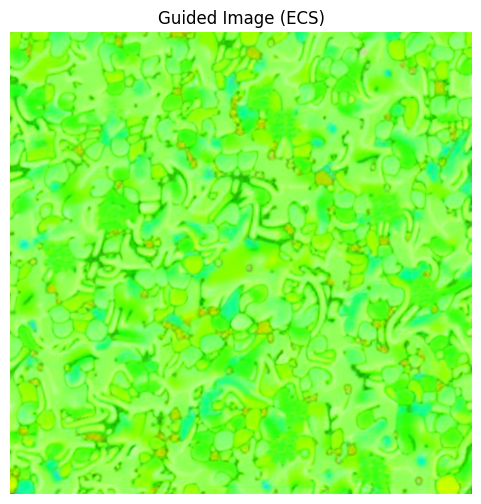

In [15]:
# Guided Image for Medium Shot (ECS)
guided_image_ecs = guided_sampling(prompt, classifier_target_label=0)
guided_image_ecs.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(guided_image_ecs)
ax.set_title("Guided Image (ECS)")
ax.axis("off")

plt.show()

In [ ]:
# Guided Image for Medium Shot (MS)
guided_image_ms = guided_sampling(prompt, classifier_target_label=2)
guided_image_ms.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(guided_image_ms)
ax.set_title("Guided Image (MS)")
ax.axis("off")

plt.show()

In [ ]:
# Guided Image for Medium Shot (LS)
guided_image_ls = guided_sampling(prompt, classifier_target_label=4)
guided_image_ls.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(guided_image_ls)
ax.set_title("Guided Image (LS)")
ax.axis("off")

plt.show()